# TPU approach

I'm learning to use TPUs (see https://www.kaggle.com/code/ryanholbrook/getting-started-with-tpus), so this is my attempt for this competition.

**Note** TPU is not currently working, I've asked in the forums https://www.kaggle.com/discussions/questions-and-answers/582296 . The notebook will also run on CPU or GPU, without any code changes.

The model itself is a simple neural network in keras - I am focusing more on using TPUs than the actual competition.

In [1]:
!pip install -q polars

In [2]:
import math, re, os
import tensorflow as tf
import numpy as np
import polars as pl
from matplotlib import pyplot as plt
#from kaggle_datasets import KaggleDatasets
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split

import pandas as pd
from sklearn.preprocessing import LabelEncoder
import kaggle_evaluation.cmi_inference_server


2025-06-03 08:44:42.939573: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748940283.137489      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748940283.193969      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# copy&paste from https://www.kaggle.com/code/ryanholbrook/getting-started-with-tpus
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None
    print("not running on TPU")

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

Tensorflow version 2.18.0
not running on TPU
REPLICAS:  1


In [4]:
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Read Data

In [5]:
# Load data
train_df = pd.read_csv("/kaggle/input/cmi-detect-behavior-with-sensor-data/train.csv")
targets = train_df[['sequence_id', 'gesture']].drop_duplicates()


In [6]:
train_df.head()

,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,tof_5_v54,tof_5_v55,tof_5_v56,tof_5_v57,tof_5_v58,tof_5_v59,tof_5_v60,tof_5_v61,tof_5_v62,tof_5_v63
0,SEQ_000007_000000,Target,SEQ_000007,0,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.683594,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,SEQ_000007_000001,Target,SEQ_000007,1,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.949219,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,SEQ_000007_000002,Target,SEQ_000007,2,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.722656,...,-1.0,-1.0,112.0,119.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,SEQ_000007_000003,Target,SEQ_000007,3,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.601562,...,-1.0,-1.0,101.0,111.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,SEQ_000007_000004,Target,SEQ_000007,4,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.566406,...,-1.0,-1.0,101.0,109.0,125.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [7]:
train_demographics = pd.read_csv("/kaggle/input/cmi-detect-behavior-with-sensor-data/train_demographics.csv")
train_demographics.head()

,subject,adult_child,age,sex,handedness,height_cm,shoulder_to_wrist_cm,elbow_to_wrist_cm
0,SUBJ_000206,1,41,1,1,172.0,50,25.0
1,SUBJ_001430,0,11,0,1,167.0,51,27.0
2,SUBJ_002923,1,28,1,0,164.0,54,26.0
3,SUBJ_003328,1,33,1,1,171.0,52,25.0
4,SUBJ_004117,0,15,0,1,184.0,54,28.0


### Merge all in one dataset

There may be smarter way to do this merge, but for now, let's put it all together.

In [8]:
train_df = train_df.merge(train_demographics, on='subject', how='left')
train_df.fillna(method='ffill', inplace=True)

/tmp/ipykernel_19/234058094.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_df.fillna(method='ffill', inplace=True)


In [9]:
train_df.head()

,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,tof_5_v61,tof_5_v62,tof_5_v63,adult_child,age,sex,handedness,height_cm,shoulder_to_wrist_cm,elbow_to_wrist_cm
0,SEQ_000007_000000,Target,SEQ_000007,0,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.683594,...,-1.0,-1.0,-1.0,0,12,1,1,163.0,52,24.0
1,SEQ_000007_000001,Target,SEQ_000007,1,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.949219,...,-1.0,-1.0,-1.0,0,12,1,1,163.0,52,24.0
2,SEQ_000007_000002,Target,SEQ_000007,2,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.722656,...,-1.0,-1.0,-1.0,0,12,1,1,163.0,52,24.0
3,SEQ_000007_000003,Target,SEQ_000007,3,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.601562,...,-1.0,-1.0,-1.0,0,12,1,1,163.0,52,24.0
4,SEQ_000007_000004,Target,SEQ_000007,4,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.566406,...,-1.0,-1.0,-1.0,0,12,1,1,163.0,52,24.0


In [10]:
train_df.describe()


,sequence_counter,acc_x,acc_y,acc_z,rot_w,rot_x,rot_y,rot_z,thm_1,thm_2,...,tof_5_v61,tof_5_v62,tof_5_v63,adult_child,age,sex,handedness,height_cm,shoulder_to_wrist_cm,elbow_to_wrist_cm
count,574945.000000,574945.000000,574945.000000,574945.000000,574945.000000,574945.000000,574945.000000,574945.000000,574945.000000,574945.000000,...,574945.000000,574945.000000,574945.000000,574945.000000,574945.000000,574945.000000,574945.000000,574945.000000,574945.000000,574945.000000
mean,43.645234,1.639980,1.790704,-0.459811,0.359589,-0.119262,-0.059807,-0.187373,27.086830,27.142138,...,31.747475,28.780502,27.129085,0.504544,21.630276,0.600247,0.875898,167.647967,51.502566,25.418165
std,45.717673,5.781259,5.003945,6.096490,0.225530,0.466052,0.543588,0.504215,3.226488,2.943012,...,60.412848,57.104146,55.324165,0.499980,10.343351,0.489848,0.329699,10.740996,4.900248,2.964853
min,0.000000,-34.585938,-24.402344,-42.855469,0.000000,-0.999146,-0.999695,-0.998169,-0.370413,21.958820,...,-1.000000,-1.000000,-1.000000,0.000000,10.000000,0.000000,0.000000,135.000000,41.000000,18.000000
25%,17.000000,-2.964844,-2.121094,-5.417969,0.179443,-0.456421,-0.512878,-0.626587,24.764328,24.545063,...,-1.000000,-1.000000,-1.000000,0.000000,13.000000,0.000000,1.000000,163.000000,49.000000,24.000000
50%,35.000000,2.972656,0.695312,-1.562500,0.339417,-0.186523,-0.112671,-0.263000,26.992983,26.372349,...,-1.000000,-1.000000,-1.000000,1.000000,20.000000,1.000000,1.000000,170.000000,52.000000,25.000000
75%,54.000000,6.343750,6.816406,5.164062,0.502502,0.205933,0.442993,0.252930,29.431932,29.631985,...,41.000000,34.000000,29.000000,1.000000,27.000000,1.000000,1.000000,174.000000,55.000000,27.000000
max,699.000000,46.328125,27.183594,30.078125,0.999390,0.999817,0.999451,0.999878,38.457664,37.578339,...,249.000000,249.000000,249.000000,1.000000,53.000000,1.000000,1.000000,190.500000,71.000000,44.000000


In [11]:
', '.join(train_df.columns.to_list())

'row_id, sequence_type, sequence_id, sequence_counter, subject, orientation, behavior, phase, gesture, acc_x, acc_y, acc_z, rot_w, rot_x, rot_y, rot_z, thm_1, thm_2, thm_3, thm_4, thm_5, tof_1_v0, tof_1_v1, tof_1_v2, tof_1_v3, tof_1_v4, tof_1_v5, tof_1_v6, tof_1_v7, tof_1_v8, tof_1_v9, tof_1_v10, tof_1_v11, tof_1_v12, tof_1_v13, tof_1_v14, tof_1_v15, tof_1_v16, tof_1_v17, tof_1_v18, tof_1_v19, tof_1_v20, tof_1_v21, tof_1_v22, tof_1_v23, tof_1_v24, tof_1_v25, tof_1_v26, tof_1_v27, tof_1_v28, tof_1_v29, tof_1_v30, tof_1_v31, tof_1_v32, tof_1_v33, tof_1_v34, tof_1_v35, tof_1_v36, tof_1_v37, tof_1_v38, tof_1_v39, tof_1_v40, tof_1_v41, tof_1_v42, tof_1_v43, tof_1_v44, tof_1_v45, tof_1_v46, tof_1_v47, tof_1_v48, tof_1_v49, tof_1_v50, tof_1_v51, tof_1_v52, tof_1_v53, tof_1_v54, tof_1_v55, tof_1_v56, tof_1_v57, tof_1_v58, tof_1_v59, tof_1_v60, tof_1_v61, tof_1_v62, tof_1_v63, tof_2_v0, tof_2_v1, tof_2_v2, tof_2_v3, tof_2_v4, tof_2_v5, tof_2_v6, tof_2_v7, tof_2_v8, tof_2_v9, tof_2_v10, tof_2_v1

## Prepare Targets and Feature Selection

We only use a few features for now, to simplify the model.

In [12]:

# Encode gesture labels
label_encoder = LabelEncoder()
targets['gesture_enc'] = label_encoder.fit_transform(targets['gesture'])
gesture2id = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Features to use (IMU only)
FEATURES = [
    'acc_x', 'acc_y', 'acc_z',
    'rot_w', 'rot_x', 'rot_y', 'rot_z'
]



In [13]:

# Feature selection
IMU_FEATURES = ['acc_x', 'acc_y', 'acc_z', 'rot_w', 'rot_x', 'rot_y', 'rot_z']
THERMO_FEATURES = [f'thm_{i}' for i in range(1, 6)]
TOF_FEATURES = [f'tof_{i}_v{j}' for i in range(1, 6) for j in range(64)]
DEMO_FEATURES = ['adult_child', 'age', 'sex', 'handedness', 'height_cm', 'shoulder_to_wrist_cm', 'elbow_to_wrist_cm']

FEATURES = IMU_FEATURES + THERMO_FEATURES + DEMO_FEATURES  + TOF_FEATURES 

## Prepare Sequences

In [14]:
# Prepare sequences
sequence_ids = train_df['sequence_id'].unique()
X, y, y_binary = [], [], []

def is_bfrb(label_id):
    label_name = label_encoder.inverse_transform([label_id])[0]
    return int(label_name != 'non_target')

expected_feature_dim = len(FEATURES)
print(f"Expecting feature size: {expected_feature_dim}")

for seq_id in sequence_ids:
    df = train_df[train_df['sequence_id'] == seq_id]

    #print(seq_id)
    
    # Skip if any FEATURE is missing
    if df[FEATURES].isnull().values.any():
        continue

    x = df[FEATURES].values.astype(np.float32)
    
    # Pad or truncate to fixed length
    if x.shape[0] < 64:
        pad_width = 64 - x.shape[0]
        x = np.pad(x, ((0, pad_width), (0, 0)), mode='edge')
    else:
        x = x[:64]
    
    # Final shape check
    if x.shape != (64, expected_feature_dim):
        print(f"Skipping sequence {seq_id} with bad shape: {x.shape}")
        continue

    # Append class and binary labels
    X.append(x)
    label = targets.loc[targets['sequence_id'] == seq_id, 'gesture_enc'].values[0]
    y.append(label)
    y_binary.append(is_bfrb(label))

X = np.stack(X)
y = np.array(y)
y_binary = np.array(y_binary)
print(f"Final shape of X: {X.shape}")


Expecting feature size: 339
Final shape of X: (8151, 64, 339)


In [15]:
# X_train, X_val, y_train_class, y_val_class, y_train_bin, y_val_bin = train_test_split(
#     X, y, y_binary, test_size=0.1, stratify=y, random_state=42
# )
# BATCH_SIZE = 64 * strategy.num_replicas_in_sync


In [16]:
# Split features into time-series and demographic parts
X_time = X[:, :, :len(IMU_FEATURES + THERMO_FEATURES + TOF_FEATURES)]
X_demo = X[:, 0, -len(DEMO_FEATURES):]  # Take demo features from first timestep

# Train/validation split
X_train_time, X_val_time, X_train_demo, X_val_demo, y_train_class, y_val_class, y_train_bin, y_val_bin = train_test_split(
    X_time, X_demo, y, y_binary, test_size=0.1, stratify=y, random_state=42
)

# Define datasets
BATCH_SIZE = 64 * strategy.num_replicas_in_sync
train_ds = tf.data.Dataset.from_tensor_slices((
    {
        "time_series": X_train_time,
        "demographics": X_train_demo
    },
    {
        "class_output": y_train_class,
        "binary_output": y_train_bin
    }
)).shuffle(1024).batch(BATCH_SIZE).prefetch(AUTO)

val_ds = tf.data.Dataset.from_tensor_slices((
    {
        "time_series": X_val_time,
        "demographics": X_val_demo
    },
    {
        "class_output": y_val_class,
        "binary_output": y_val_bin
    }
)).batch(BATCH_SIZE).prefetch(AUTO)


I0000 00:00:1748940682.843014      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


## Build TPU model

Apparently Keras is easier for developing TPU models.

In [17]:
def build_bfrb_model(architecture: str, input_shapes: dict, num_classes: int) -> tf.keras.Model:
    def se_block(input_tensor, ratio=8):
        channel_axis = -1
        filters = input_tensor.shape[channel_axis]
        se_shape = (1, filters)

        se = tf.keras.layers.GlobalAveragePooling1D()(input_tensor)
        se = tf.keras.layers.Reshape(se_shape)(se)
        se = tf.keras.layers.Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
        se = tf.keras.layers.Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
        return tf.keras.layers.Multiply()([input_tensor, se])

    def residual_se_cnn_block(x, filters, kernel_size):
        shortcut = x
        x = tf.keras.layers.Conv1D(filters, kernel_size, padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.Conv1D(filters, kernel_size, padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = se_block(x)
        x = tf.keras.layers.Add()([x, shortcut])
        x = tf.keras.layers.ReLU()(x)
        return x

    def attention_block(inputs):
        query = tf.keras.layers.Dense(64)(inputs)
        key = tf.keras.layers.Dense(64)(inputs)
        value = tf.keras.layers.Dense(64)(inputs)
        attention = tf.keras.layers.Attention()([query, key, value])
        return tf.keras.layers.GlobalAveragePooling1D()(attention)

    time_input = tf.keras.Input(shape=input_shapes['time_series'], name="time_series")
    demo_input = tf.keras.Input(shape=input_shapes['demographics'], name="demographics")

    # --- Time-series branch ---
    x = time_input
    if architecture == "A1":
        x = tf.keras.layers.Conv1D(64, 5, padding='same', activation='relu')(x)
        x = tf.keras.layers.Conv1D(128, 5, padding='same', activation='relu')(x)
        x = tf.keras.layers.GlobalAveragePooling1D()(x)
    elif architecture == "A2":
        x = tf.keras.layers.Conv1D(64, 5, padding='same', activation='relu')(x)
        x = tf.keras.layers.Conv1D(128, 5, padding='same', activation='relu')(x)
        x = tf.keras.layers.Conv1D(256, 3, padding='same', activation='relu')(x)
        x = tf.keras.layers.GlobalAveragePooling1D()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
    elif architecture == "A3":
        x = tf.keras.layers.Conv1D(64, 5, padding='same', activation='relu')(x)
        x = tf.keras.layers.Conv1D(128, 5, padding='same', activation='relu')(x)
        x = tf.keras.layers.LSTM(64, return_sequences=True)(x)
        x = attention_block(x)
    elif architecture == "A4":
        x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
        x = attention_block(x)
    elif architecture == "A6":
        x = tf.keras.layers.Conv1D(64, 5, padding='same', activation='relu')(x)
        x = tf.keras.layers.Conv1D(128, 5, padding='same', activation='relu')(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
    elif architecture == "A7":
        x = tf.keras.layers.Conv1D(64, 5, padding='same', activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Conv1D(128, 5, padding='same', activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.GlobalAveragePooling1D()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
    elif architecture == "A8":
        x = tf.keras.layers.Conv1D(64, 5, padding='same')(x)
        x = residual_se_cnn_block(x, 64, 5)
        x = residual_se_cnn_block(x, 64, 5)
        x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
        x = attention_block(x)
    else:
        raise ValueError(f"Unknown architecture ID: {architecture}")

    x = tf.keras.layers.Dense(128, activation='relu')(x)

    # --- Demographic branch ---
    d = tf.keras.layers.Dense(64, activation='relu')(demo_input)
    d = tf.keras.layers.Dense(32, activation='relu')(d)

    # --- Merge branches ---
    merged = tf.keras.layers.Concatenate()([x, d])
    merged = tf.keras.layers.Dense(128, activation='relu')(merged)

    # --- Heads ---
    class_output = tf.keras.layers.Dense(num_classes, activation='softmax', name='class_output')(merged)
    binary_output = tf.keras.layers.Dense(1, activation='sigmoid', name='binary_output')(merged)

    model = tf.keras.Model(inputs=[time_input, demo_input], outputs=[class_output, binary_output])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss={
            'class_output': tf.keras.losses.SparseCategoricalCrossentropy(),
            'binary_output': tf.keras.losses.BinaryCrossentropy(),
        },
        metrics={
            'class_output': 'accuracy',
            'binary_output': 'accuracy',
        }
    )
    return model

with strategy.scope():
    model = build_bfrb_model(
        architecture="A8",
        input_shapes={
            "time_series": (64, len(IMU_FEATURES + THERMO_FEATURES + TOF_FEATURES)),  # e.g. (64, 332)
            "demographics": (len(DEMO_FEATURES),)     # e.g. (7,)
        },
        num_classes=len(label_encoder.classes_)
    )


## Train!

TODO: implement cross-validation in TPUs

In [18]:
# Train

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_class_output_loss',
    patience=10,
    restore_best_weights=True, mode="min"
)

history = model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[early_stop])


Epoch 1/50


I0000 00:00:1748940698.216611      64 cuda_dnn.cc:529] Loaded cuDNN version 90300


115/115 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - binary_output_accuracy: 0.9865 - binary_output_loss: 0.0668 - class_output_accuracy: 0.0970 - class_output_loss: 4.6423 - loss: 4.7313 - val_binary_output_accuracy: 1.0000 - val_binary_output_loss: 0.0018 - val_class_output_accuracy: 0.1740 - val_class_output_loss: 2.6441 - val_loss: 2.6581
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - binary_output_accuracy: 1.0000 - binary_output_loss: 0.0019 - class_output_accuracy: 0.1880 - class_output_loss: 2.5405 - loss: 2.5531 - val_binary_output_accuracy: 1.0000 - val_binary_output_loss: 0.0011 - val_class_output_accuracy: 0.2010 - val_class_output_loss: 2.3544 - val_loss: 2.3608
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - binary_output_accuracy: 1.0000 - binary_output_loss: 0.0010 - class_output_accuracy: 0.2275 - class_output_loss: 2.3164 - loss: 2.3235 - val_binary_output_accuracy: 1.0000 - val_binary_output_loss: 7.3792e-04 - val_class_output_accuracy: 0.2181 - val_class_outp

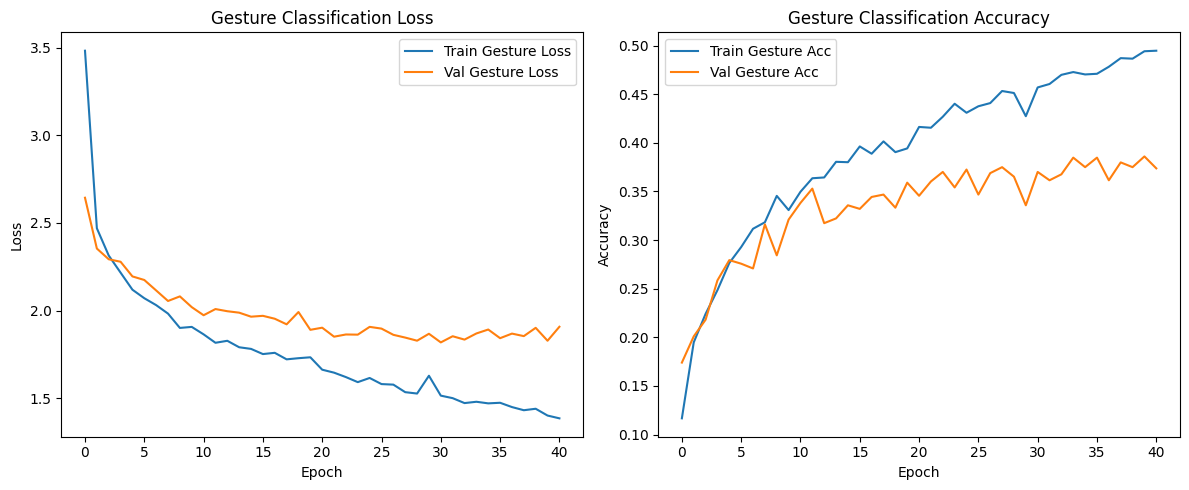

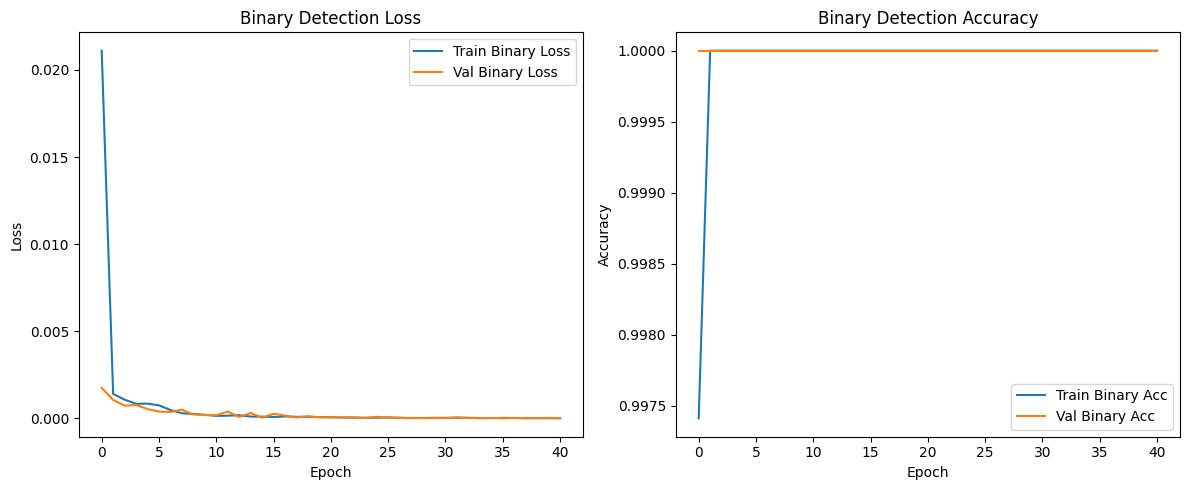

In [19]:
import matplotlib.pyplot as plt

# Plot classification (gesture) loss and accuracy
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['class_output_loss'], label='Train Gesture Loss')
plt.plot(history.history['val_class_output_loss'], label='Val Gesture Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Gesture Classification Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['class_output_accuracy'], label='Train Gesture Acc')
plt.plot(history.history['val_class_output_accuracy'], label='Val Gesture Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Gesture Classification Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Plot binary head loss and accuracy
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['binary_output_loss'], label='Train Binary Loss')
plt.plot(history.history['val_binary_output_loss'], label='Val Binary Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Binary Detection Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['binary_output_accuracy'], label='Train Binary Acc')
plt.plot(history.history['val_binary_output_accuracy'], label='Val Binary Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Binary Detection Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
Validation Classification Report:
                                            precision    recall  f1-score   support

                     Above ear - pull hair       0.47      0.56      0.51        64
                        Cheek - pinch skin       0.31      0.27      0.29        64
                     Drink from bottle/cup       0.75      0.56      0.64        16
                       Eyebrow - pull hair       0.24      0.36      0.29        64
                       Eyelash - pull hair       0.27      0.11      0.16        64
Feel around in tray and pull out an object       0.82      0.56      0.67        16
                  Forehead - pull hairline       0.43      0.39      0.41        64
                        Forehead - scratch       0.32      0.31      0.32        64
                            Glasses on/off       0.47      0.44      0.45        16
                         Neck - pinch skin       0.37      0.31      0.34        64
 

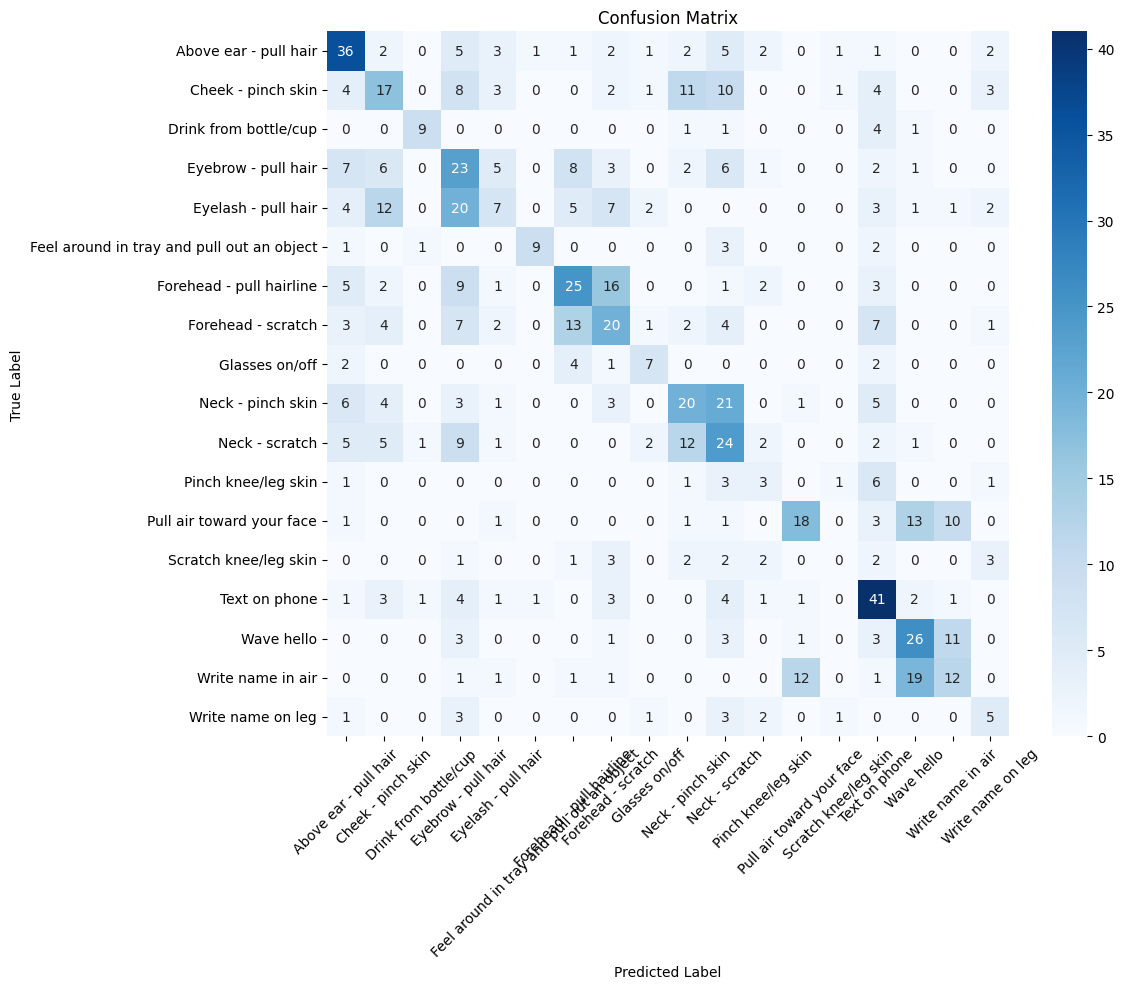

Binary F1: 1.0000, Macro F1: 0.3667, Final Score: 0.6833
Binary F1: 1.0000, Macro F1: 0.3667, Final Score: 0.6833


In [20]:
# Evaluate model (multi-head)
val_preds = model.predict(val_ds)
gesture_preds = val_preds[0]  # class_output
binary_preds = val_preds[1]   # binary_output

y_val_pred = np.argmax(gesture_preds, axis=1)
binary_pred = (binary_preds > 0.5).astype(int).flatten()

from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

print("Validation Classification Report:")
print(classification_report(y_val_class, y_val_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_val_class, y_val_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

binary_true = np.isin(y_val_class, [label_encoder.transform([g])[0] for g in label_encoder.classes_ if g != 'non_target']).astype(int)
binary_pred = np.isin(y_val_pred, [label_encoder.transform([g])[0] for g in label_encoder.classes_ if g != 'non_target']).astype(int)

binary_f1 = f1_score(binary_true, binary_pred)
macro_f1 = f1_score(y_val_class, y_val_pred, average='macro')
final_score = 0.5 * (binary_f1 + macro_f1)

print(f"Binary F1: {binary_f1:.4f}, Macro F1: {macro_f1:.4f}, Final Score: {final_score:.4f}")

print(f"Binary F1: {binary_f1:.4f}, Macro F1: {macro_f1:.4f}, Final Score: {final_score:.4f}")


Binary Classification Report:
              precision    recall  f1-score   support

  non_target       0.00      0.00      0.00         0
      target       1.00      1.00      1.00       816

   micro avg       1.00      1.00      1.00       816
   macro avg       0.50      0.50      0.50       816
weighted avg       1.00      1.00      1.00       816



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.

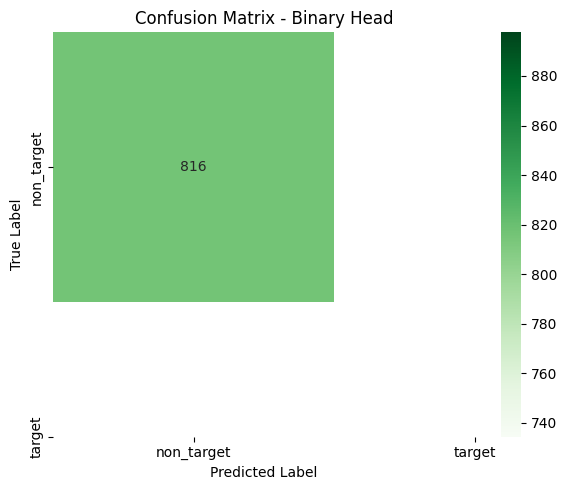

In [21]:
# Ground truth binary labels (1 = target, 0 = non-target)
binary_true = np.isin(y_val_class, [
    label_encoder.transform([g])[0] 
    for g in label_encoder.classes_ if g != 'non_target'
]).astype(int)

# Already computed earlier: binary_pred = (binary_preds > 0.5).astype(int).flatten()

# Binary classification report
print("\nBinary Classification Report:")
print(classification_report(
    binary_true, 
    binary_pred, 
    labels=[0, 1], 
    target_names=['non_target', 'target']
))


# Binary confusion matrix
binary_cm = confusion_matrix(binary_true, binary_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(binary_cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['non_target', 'target'], 
            yticklabels=['non_target', 'target'])
plt.title("Confusion Matrix - Binary Head")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()


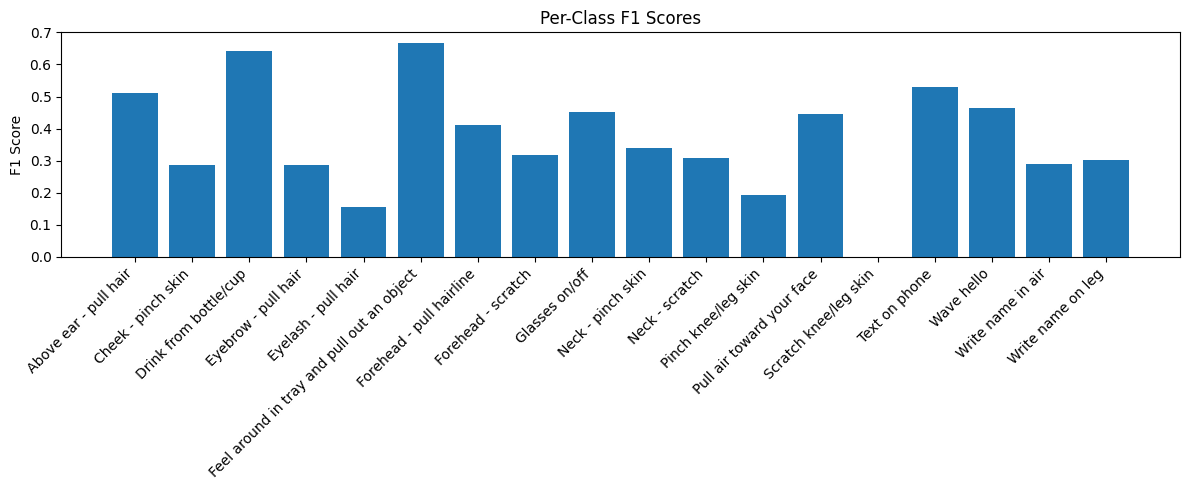

In [22]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

f1_per_class = f1_score(y_val_class, y_val_pred, average=None)
plt.figure(figsize=(12, 5))
plt.bar(label_encoder.classes_, f1_per_class)
plt.xticks(rotation=45, ha='right')
plt.ylabel("F1 Score")
plt.title("Per-Class F1 Scores")
plt.tight_layout()
plt.show()


In [23]:
binary_f1 = f1_score(binary_true, binary_pred)
macro_f1 = f1_score(y_val_class, y_val_pred, average='macro')
final_score = 0.5 * (binary_f1 + macro_f1)

print(f"Binary F1: {binary_f1:.4f}, Macro F1: {macro_f1:.4f}, Final Score: {final_score:.4f}")


Binary F1: 1.0000, Macro F1: 0.3667, Final Score: 0.6833


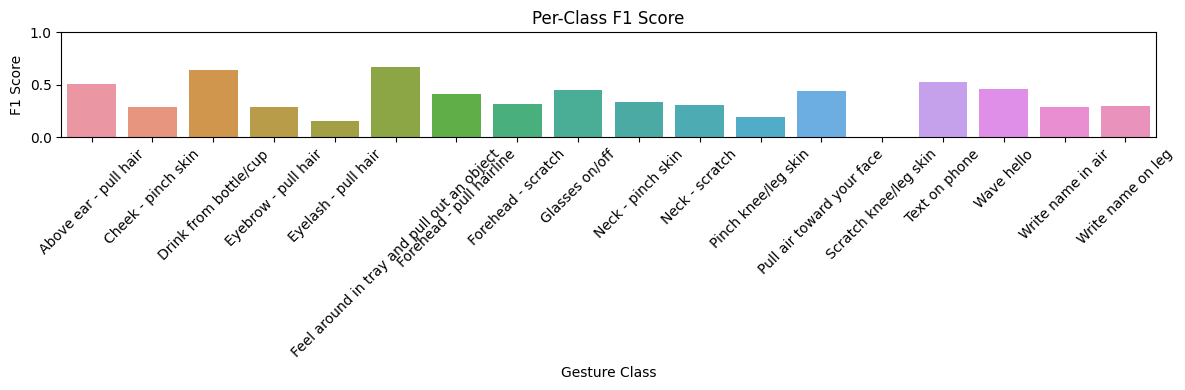

In [24]:
# Visualize gesture-wise F1 scores:

from sklearn.metrics import precision_recall_fscore_support

_, _, f1s, _ = precision_recall_fscore_support(y_val_class, y_val_pred, labels=range(len(label_encoder.classes_)))
plt.figure(figsize=(12, 4))
sns.barplot(x=label_encoder.classes_, y=f1s)
plt.xticks(rotation=45)
plt.title("Per-Class F1 Score")
plt.ylabel("F1 Score")
plt.xlabel("Gesture Class")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


In [25]:
#model.save("./model")
#pd.Series(label_encoder.classes_).to_csv("gesture_labels.csv", index=False)


## Create Submission Interface

In [26]:
def predict(sequence, demographics) -> str:
    # Convert to pandas if needed
    sequence = sequence.to_pandas()
    demographics = demographics.to_pandas()
    
    # Merge and fill missing
    df = pd.merge(sequence, demographics, on='subject', how='left')
    df.fillna(method='ffill', inplace=True)

    # Extract features
    x_time = df[IMU_FEATURES + THERMO_FEATURES + TOF_FEATURES].values.astype(np.float32)
    x_demo = df[DEMO_FEATURES].iloc[0].values.astype(np.float32)  # take from first row

    # Pad/crop time-series
    if x_time.shape[0] < 64:
        pad_width = 64 - x_time.shape[0]
        x_time = np.pad(x_time, ((0, pad_width), (0, 0)), mode='edge')
    else:
        x_time = x_time[:64]

    # Add batch dimension
    x_time = np.expand_dims(x_time, axis=0)
    x_demo = np.expand_dims(x_demo, axis=0)

    # Predict
    class_probs, _ = model.predict({"time_series": x_time, "demographics": x_demo}, verbose=0)
    pred_idx = np.argmax(class_probs[0])
    return label_encoder.inverse_transform([pred_idx])[0]


# Launch evaluation server
inference_server = kaggle_evaluation.cmi_inference_server.CMIInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        data_paths=(
            '/kaggle/input/cmi-detect-behavior-with-sensor-data/test.csv',
            '/kaggle/input/cmi-detect-behavior-with-sensor-data/test_demographics.csv',
        )
    )

/tmp/ipykernel_19/1436462931.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/tmp/ipykernel_19/1436462931.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
